# Motion Graph

by Lucas Kovar, Michael Gleicher, Frédéric Pighin  
Siggraph 2002

Notebook by Jerome Eippers, 2024

In [1]:
%matplotlib widget
from dataclasses import dataclass, field
from random import randrange
import numpy as np
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt
from matplotlib import colors as plt_color
import warp as wp

import ipyanimlab as lab
wp.init()
viewer = lab.Viewer(move_speed=5, width=1280, height=720)

Warp 1.1.0 initialized:
   CUDA Toolkit 11.5, Driver 12.4
   Devices:
     "cpu"      : "Intel64 Family 6 Model 85 Stepping 4, GenuineIntel"
     "cuda:0"   : "NVIDIA GeForce RTX 2070" (8 GiB, sm_75, mempool enabled)
   Kernel cache:
     C:\Users\jerome.eippers\AppData\Local\NVIDIA\warp\Cache\1.1.0


In [2]:
# pre allocate memory
# a = wp.empty(1024*1024*10*60, dtype=wp.vec3, device="cuda:0")
# b = wp.empty(1024*10*60, dtype=wp.vec3, device="cuda:0")
# c = wp.empty(10*60, dtype=wp.vec3, device="cuda:0")

In [3]:
character = viewer.import_usd_asset('AnimLabSimpleMale.usd')

In [4]:
animmap = lab.AnimMapper(character, root_motion=True, match_effectors=True, local_offsets={'Hips':[0, 2, 0]})
animation = lab.import_bvh('../../resources/lafan1/bvh/walk1_subject5.bvh', anim_mapper=animmap)

frame_count = animation.quats.shape[0]
bone_count = character.bone_count()

In [5]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_axis(character.world_skeleton_xforms(a), 5)
    viewer.draw_lines(character.world_skeleton_lines(a))
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Keep only a few ranges
We will split the animation into several small clips. (as if they were coming from different animations, to make the database smaller)

Then we will append all the clips together into one big animation to make the algorithm simpler.

In [6]:
# add a padding around our clip extraction, this is to ensure that we will have the data for the window of frame later in the algorithm.
padding_frame_count = 10

# this is the ranges we keep inside this animation
ranges = np.asarray([[80,350],[1185,1800],[6997,7287]], dtype=np.int32)

# the new framecount
frame_count = np.sum(ranges[:,1] - ranges[:,0]) + padding_frame_count*2*ranges.shape[0]

# build the animation
pos = np.zeros([frame_count, bone_count, 3], dtype=np.float32)
quats = np.zeros([frame_count, bone_count, 4], dtype=np.float32)
index=0
for i in range(ranges.shape[0]):
    length = ranges[i,1] - ranges[i,0] + padding_frame_count*2 
    pos[index:index+length, :, :] = animation.pos[ranges[i][0]-padding_frame_count:ranges[i][1]+padding_frame_count, :, :]
    quats[index:index+length, :, :] = animation.quats[ranges[i][0]-padding_frame_count:ranges[i][1]+padding_frame_count, :, :]
    index +=  length

animation.pos = pos
animation.quats = quats

## Build point cloud

In [7]:
point_cloud_def = [
    ["Hips", [10.406591210663493, -8.553789115186634, -12.49173281163814]],
    ["Hips", [7.494161330381544, -13.077808575007687, 0.9426891396191638]],
    ["Hips", [7.7249520044646545, -6.545964046486256, 14.01880809446177]],
    ["Hips", [9.751970451204315, 8.625782141788662, 8.979432281554473]],
    ["Hips", [10.232707838754962, 9.34891887390035, -7.538683709592022]],
    ["RightUpLeg", [25.428533521722485, 2.8875165217815795, -6.878924295813136]],
    ["RightUpLeg", [8.719673829402424, 9.825064657690273, -0.7720172886301881]],
    ["RightUpLeg", [5.811665595654219, -11.98327752415305, 2.3792780165553022]],
    ["RightUpLeg", [28.33690387259628, -8.41487476189993, 1.3021494892135212]],
    ["RightLeg", [13.150925491109753, -7.161046295160561, 5.361214662571747]],
    ["RightLeg", [5.859375996726911, 5.041840968355539, 0.23247957315766676]],
    ["RightLeg", [17.72812750201802, -1.133053969070116, -4.010949247743784]],
    ["RightLeg", [26.22613415874257, 3.051063535090055, 3.9952256145582012]],
    ["RightFoot", [1.6913448778473148, 1.4391739257848624, 3.024892133966274]],
    ["RightFoot", [6.041579950619017, 13.114785261459179, 4.152351051920569]],
    ["RightFoot", [-0.7607285664424648, 6.4172807256444, -1.123198259968282]],
    ["RightFoot", [4.017341831832558, 13.069596737133754, -3.4436449813779433]],
    ["RightFoot", [3.7495590191569317, -0.2537134077241907, -3.3694467583819137]],
    ["LeftUpLeg", [25.12247134886981, 3.6743709290426976, 6.563177823958194]],
    ["LeftUpLeg", [9.551957286908873, 10.23611801388595, -1.9077360068510316]],
    ["LeftUpLeg", [28.65813094429042, -8.35918541893486, -1.3339897839171755]],
    ["LeftUpLeg", [4.395924591130509, -11.499569286438895, -3.485358940906284]],
    ["LeftLeg", [18.335434660817796, -7.548672511243447, 2.0012604965142113]],
    ["LeftLeg", [8.063084862215781, -5.447030007461844, -6.009867191587116]],
    ["LeftLeg", [28.03159871908633, 1.7117996654053318, -4.752031496102575]],
    ["LeftLeg", [6.431504525829688, 4.9434519087186715, -0.8806493560847066]],
    ["LeftFoot", [4.056454883378393, 1.121819696337233, 3.8483745715606155]],
    ["LeftFoot", [5.161194315776309, 12.292334453561939, -3.006955809950556]],
    ["LeftFoot", [0.3394773466348564, 6.849790842987641, 0.28227692753535827]],
    ["LeftFoot", [5.511888891253647, 0.5714734086522908, -3.0863151739836674]],
    ["LeftFoot", [3.9787466905628905, 14.381266444981136, 2.479515523426212]],
    ["Spine1", [9.496055166365181, 13.261681617632604, 0.4618944499019954]],
    ["Spine2", [4.638372103681348, 11.542082848169862, -9.173969243617712]],
    ["Spine2", [4.990344792529044, 10.985310645869411, 10.196818749486237]],
    ["Spine2", [9.333232383526394, -12.316429843384684, 7.305572162709259]],
    ["Spine2", [9.646418956259112, -12.508791115297752, -8.202794838375942]],
    ["Spine2", [24.97764834055124, -5.685494039531465, 0.07047543301694105]],
    ["RightShoulder", [12.01833866519815, -2.2499398844760234, -6.316927060772201]],
    ["RightArm", [12.51343492254695, -5.249092455288757, 0.21239511633578445]],
    ["RightArm", [23.379428771038384, 2.5841745190828673, -1.0884919917317006]],
    ["RightForeArm", [6.676740368863612, -3.097260692802813, -3.074014189204462]],
    ["RightForeArm", [23.195125043648968, 2.551374762885576, -1.2453554680053003]],
    ["RightHand", [4.684195023120278, -0.388571402389573, -3.7730386523041606]],
    ["RightHand", [3.4296308448508235, 0.0823092812901507, 3.79142970412574]],
    ["LeftArm", [24.514363324311894, 2.8079841486126123, 0.7185463599518869]],
    ["LeftArm", [15.06176263150239, -5.809261036766776, -1.9100543106347914]],
    ["LeftForeArm", [21.357126227101908, 2.898611736699843, 0.6698217392704748]],
    ["LeftForeArm", [10.815876472733368, -4.52680953256159, 1.0269067244147152]],
    ["LeftHand", [5.743740511570127, -0.16993932883508478, 4.063152412932427]],
    ["LeftHand", [3.858676279461285, -0.77220456567224, -3.1843255294994446]],
    ["LeftShoulder", [12.471540098604782, -0.5468968923397659, 6.561813229097737]],
    ["Head", [13.36365126480294, -4.423986534711485, -6.435934325301026]],
    ["Head", [13.204342548716056, 8.740483696093971, 0.33548883622346937]],
    ["Head", [11.657067522145155, -5.234603532431638, 6.817363823200325]]
]
point_count = len(point_cloud_def)
point_cloud_parent = np.zeros([point_count], dtype=np.int32)
point_cloud_local = np.zeros([point_count, 3], dtype=np.float32)
for i, point in enumerate(point_cloud_def):
    point_cloud_parent[i] = character.bone_index(point[0])
    point_cloud_local[i, :] = point[1] 

In [8]:
cloud_animation = np.zeros([frame_count, point_count, 3], dtype=np.float32)

gquats, gpos = lab.utils.quat_fk(animation.quats, animation.pos, animation.parents)
for i in range(point_count):
    cloud_animation[:, i, :] = lab.utils.quat_mul_vec(gquats[:, point_cloud_parent[i], :], point_cloud_local[np.newaxis, i, :]) + gpos[:, point_cloud_parent[i], :]

In [9]:
def render(frame, window=1):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    cloud_matrices = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(point_count, axis=0)
    for w in range(abs(window)):
        if window<0:
            w = -w
        if frame+w < frame_count:
            cloud_matrices[:, :3, 3] = cloud_animation[frame+w, :, :]
            viewer.draw_axis(cloud_matrices, 2)  
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1),
    window=widgets.IntSlider(1, min=-10, max=10)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Find the alignment and errors

In [10]:
def point_cloud_alignment(a, b, weights):
    sw = np.sum(weights)
    sax = np.sum(weights * a[:, 0])
    saz = np.sum(weights * a[:, 2])
    sbx = np.sum(weights * b[:, 0])
    sbz = np.sum(weights * b[:, 2])
    
    n = np.sum(weights*(a[:,0] * b[:,2] - b[:,0] * a[:,2])) - (sax*sbz-sbx*saz)/sw
    d = np.sum(weights*(a[:,0] * b[:,0] + b[:,2] * a[:,2])) - (sax*sbx+sbz*saz)/sw
    
    angle = np.arctan2(n,d)
    x = (sax - sbx*np.cos(angle) - sbz*np.sin(angle))/sw
    z = (saz + sbx*np.sin(angle) - sbz*np.cos(angle))/sw
    
    return angle, x, z

In [11]:
window_size = 10

out = widgets.Output()

def render(frame_a, frame_b, t):
    
    frame_b = max(frame_b, window_size)
    frame_a = min(frame_a, frame_count-window_size)
    
    t = -2.0*t**3 + 3*t**2
    
    anim = animation
    p = (anim.pos[frame_a,...])
    q = (anim.quats[frame_a,...])
    
    p_b = (anim.pos[frame_b,...]).copy()
    q_b = (anim.quats[frame_b,...]).copy()
    
    blend_a_p = (anim.pos[int(frame_a+float(window_size)*t),...])
    blend_a_q = (anim.quats[int(frame_a+float(window_size)*t),...])
    
    blend_b_p = (anim.pos[int(frame_b-float(window_size)*(1.0-t)),...]).copy()
    blend_b_q = (anim.quats[int(frame_b-float(window_size)*(1.0-t)),...]).copy()
    
    blend_b_q[0], blend_b_p[0] = lab.utils.qp_mul(lab.utils.qp_inv((q_b[0:1], p_b[0:1])), (blend_b_q[0:1], blend_b_p[0:1]))
    
    # get the clouds
    weights = np.ones([point_count*window_size], dtype=np.float32)
    cloud_a = np.zeros([point_count*window_size, 3], dtype=np.float32)
    cloud_b = np.zeros([point_count*window_size, 3], dtype=np.float32)
    
    cloud_a[:, :] = cloud_animation[frame_a:frame_a+window_size, :, :].reshape([point_count*window_size, 3])
    cloud_b[:, :] = cloud_animation[frame_b-window_size+1:frame_b+1, :, :].reshape([point_count*window_size, 3])
        
    # compute the offset between the clouds
    angle, x, z = point_cloud_alignment(cloud_a, cloud_b, weights)
    
    off_q = np.asarray([np.cos(angle/2),0,np.sin(angle/2),0], dtype=np.float32)
    
    q_b[0] = lab.utils.quat_mul(off_q, q_b[0])
    p_b[0] = lab.utils.quat_mul_vec(off_q[np.newaxis,...], p_b[0])
    p_b[0, 0] += x
    p_b[0, 2] += z
    
    blend_b_q[0], blend_b_p[0] = lab.utils.qp_mul((q_b[0:1], p_b[0:1]), (blend_b_q[0:1], blend_b_p[0:1]))
    
    p_c = (1.0-t)*blend_a_p + t*blend_b_p
    q_c = lab.utils.quat_slerp(blend_a_q, blend_b_q, t)

    # display the meshes
    a = lab.utils.quat_to_mat(q, p)
    b = lab.utils.quat_to_mat(q_b, p_b)
    c = lab.utils.quat_to_mat(q_c, p_c)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.draw(character, b)
    viewer.draw(character, c)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.draw(character, b)
    viewer.draw(character, c)
    viewer.end_display()

    viewer.disable(depth_test=True)
    
    # display point clouds
    cloud_b = lab.utils.quat_mul_vec(off_q[np.newaxis,...], cloud_b)
    cloud_b[:, 0] += x
    cloud_b[:, 2] += z
    
    cloud_matrices = np.eye(4, dtype=np.float32)[np.newaxis,...].repeat(point_count, axis=0)
    for i in range(window_size):
        cloud_matrices[:, :3, 3] = cloud_a[point_count*i:point_count*(i+1)]
        viewer.draw_axis(cloud_matrices, 2)  
        cloud_matrices[:, :3, 3] = cloud_b[point_count*i:point_count*(i+1)]
        viewer.draw_axis(cloud_matrices, 2) 
  

    d = cloud_a - cloud_b
    dist = np.sum(np.sqrt(np.sum(d*d, axis=-1)))
    out.clear_output(True)
    with out:
        print ( "angle : {}, x : {}, y : {}, distance : {}".format(angle,x,z,dist) )
    
    viewer.execute_commands()
    
interact(
    render, 
    frame_a=lab.Timeline(min=0, max=frame_count-1),
    frame_b=lab.Timeline(min=0, max=frame_count-1),
    t=widgets.FloatSlider(min=0, max=1)
)
display(out)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Output()

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Build the potential transition points

In [14]:
@wp.func
def wp_point_cloud_alignment(a:wp.array(dtype = wp.vec3), b:wp.array(dtype = wp.vec3), weights:wp.array(dtype = float)):

    sw = float(0)
    sax = float(0)
    saz = float(0)
    sbx = float(0)
    sbz = float(0)
    
    for i in range(weights.shape[0]):
        sw += weights[i]
        sax += weights[i] * a[i][0]
        saz += weights[i] * a[i][2]
        sbx += weights[i] * b[i][0]
        sbz += weights[i] * b[i][2]
        
    n = float(0)
    d = float(0)
    
    for i in range(weights.shape[0]):
        n += weights[i] * (a[i][0] * b[i][2] - b[i][0] * a[i][2])
        d += weights[i] * (a[i][0] * b[i][0] + b[i][2] * a[i][2])
    
    n -= (sax*sbz-sbx*saz)/sw
    d -= (sax*sbx+sbz*saz)/sw
    
    angle = wp.atan2(n, d)
    x = (sax - sbx*wp.cos(angle) - sbz*wp.sin(angle))/sw
    z = (saz + sbx*wp.sin(angle) - sbz*wp.cos(angle))/sw
    return angle, x, z
    

@wp.kernel
def wp_compute_distances(
    cloud_a: wp.array(shape=(0,0), dtype = wp.vec3),
    cloud_b: wp.array(shape=(0,0), dtype = wp.vec3),
    weights: wp.array(dtype = float),
    out_transform: wp.array(shape=(0,0), dtype = wp.vec3),
    out_distance: wp.array(shape=(0,0), dtype = float)):
    
    i, j = wp.tid() 
    frame_count = cloud_a.shape[0]
    point_count = cloud_a.shape[1]
    
    angle, x, z = wp_point_cloud_alignment(cloud_a[i], cloud_b[j], weights)
    out_transform[i, j] = wp.vec3f(angle, x, z)
    
    sina = wp.sin(angle)
    cosa = wp.cos(angle)
    error = float(0)
    
    for c in range(point_count):
        px = cloud_b[j, c][0]
        py = cloud_b[j, c][1]
        pz = cloud_b[j, c][2]

        error += weights[c] * wp.length(cloud_a[i, c] - wp.vec3f(
            px * cosa + pz * sina + x,
            py,
            pz * cosa - px * sina + z
        ))

    out_distance[i,j] = error

Module __main__ load on device 'cuda:0' took 1586.92 ms


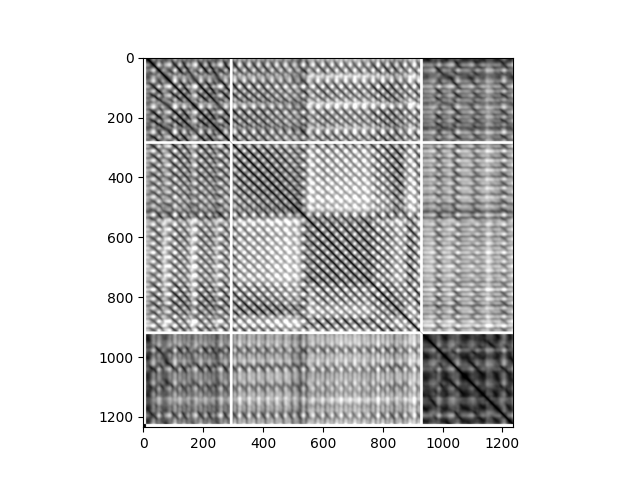

In [15]:
weights = np.ones([window_size * point_count], dtype=np.float32)
clouds_a = np.zeros([frame_count, window_size * point_count, 3], dtype=np.float32)
clouds_b = np.zeros([frame_count, window_size * point_count, 3], dtype=np.float32)

for i in range(frame_count-window_size):
    clouds_a[i, :, :] = cloud_animation[i:i+window_size, :, :].reshape([point_count*window_size, 3])
    
for j in range(window_size, frame_count):
    clouds_b[j, :, :] = cloud_animation[j-window_size+1:j+1, :, :].reshape([point_count*window_size, 3])
    
wp_weights = wp.array(weights, dtype = float)
wp_cloud_a = wp.array(clouds_a, dtype = wp.vec3)
wp_cloud_b = wp.array(clouds_b, dtype = wp.vec3)

wp_transforms = wp.empty(shape=(frame_count, frame_count), dtype = wp.vec3, device = "cuda")
wp_distances = wp.empty(shape=(frame_count, frame_count), dtype = float, device = "cuda")

wp.launch(
    kernel = wp_compute_distances, 
    inputs = [
        wp_cloud_a, wp_cloud_b, wp_weights, wp_transforms, wp_distances
    ], 
    dim = (frame_count, frame_count), 
    device = "cuda")

transforms = wp_transforms.numpy()
distances = wp_distances.numpy()

plt.clf()
plt.imshow(np.clip(distances,1000,15000), cmap=plt.cm.gray)
plt.show()

In [16]:
@wp.kernel
def wp_local_minima(
        distance: wp.array(shape=(0,0), dtype = float),
        local_min: wp.array(shape=(0,0), dtype = wp.int8),
        max_error: float,
        min_dist: int,
    ):
    
    i, j = wp.tid() 
    frame_count = distance.shape[0]
    local_min[i, j] = wp.int8(0)
    
    if i > 0 and j > 0 and i < frame_count and j < frame_count and wp.abs(j-i) > min_dist and distance[i, j] < max_error:
        if (distance[i, j] < distance[i-1, j] and 
            distance[i, j] < distance[i+1, j] and 
            distance[i, j] < distance[i, j-1] and 
            distance[i, j] < distance[i, j+1] and 
            distance[i, j] < distance[i-1, j-1] and 
            distance[i, j] < distance[i-1, j+1] and 
            distance[i, j] < distance[i+1, j+1] and 
            distance[i, j] < distance[i+1, j-1]) :
                
            local_min[i, j] = wp.int8(1)

In [17]:
wp_local_min = wp.empty(shape=(frame_count, frame_count), dtype = wp.int8, device = "cuda")

wp.launch(
    kernel = wp_local_minima, 
    inputs = [
        wp_distances, wp_local_min, 5000.0, 20
    ], 
    dim = (frame_count, frame_count), 
    device = "cuda")

local_minima = wp_local_min.numpy()

Module __main__ load on device 'cuda:0' took 1531.92 ms


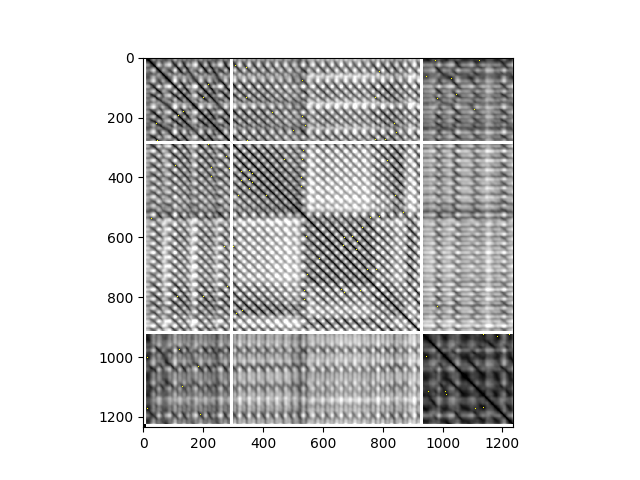

(array([0, 1], dtype=int8), array([1524270,     955], dtype=int64))

In [18]:
plt.clf()
plt.imshow(np.clip(distances,1000,15000), cmap=plt.cm.gray, interpolation='nearest')
cmap1 = plt_color.ListedColormap(['None', 'yellow'])
plt.imshow(local_minima, cmap=cmap1, vmin=0, vmax=1, interpolation='nearest')
plt.show()

np.unique(local_minima, return_counts=True)

## Build Graph

In [19]:
@dataclass
class Node:
    """A node in the graph."""
    node_id: int = 0
    start: int = 0
    end: int = 0
    edges: list[int] = field(default_factory=list)
    
@dataclass
class Edge:
    """A directed edge."""
    start_frame: int = 0
    end_frame:int = 0
    blend: bool = False
    angle: float = 0.0
    x: float = 0.0
    z: float = 0.0

    
# prepare the nodes data
nodes = []
edges = []
frame_mapping = np.ones([frame_count], dtype=np.int32)*-1

# prefill the known nodes
index=padding_frame_count
for i in range(ranges.shape[0]):
    node_id = len(nodes)
    length = ranges[i,1] - ranges[i,0]
    nodes.append(Node(node_id=node_id, start=index, end=index+length-1))
    frame_mapping[index:index+length] = node_id
    index += length + padding_frame_count*2


In [20]:
for i in range(frame_count):
    for j in range(frame_count):
        if local_minima[i, j] == 1:
            
            # find where we start from
            start_node_id = frame_mapping[i]
            if start_node_id < 0:
                continue # out of range
            
            node = nodes[start_node_id]
            
            # check if we have to split the node
            if node.end > i:
                node_id = len(nodes)
                nodes.append(Node(node_id=node_id, start=i+1, end=node.end))
                frame_mapping[i+1:node.end+1] = node_id
                node.end = i
                e = Edge(start_frame=i, end_frame=i+1)
                edges.append(e)
                node.edges.append(e)
                
            # add the edge
            e = Edge(start_frame=i, end_frame=j+1, blend=True, angle=transforms[i,j,0], x=transforms[i,j,1], z=transforms[i,j,2])
            edges.append(e)
            node.edges.append(e)    

## Prune the graph

In [21]:
#Tarjan scc algorithm

@dataclass
class SCCNode:
    """A node in the graph."""
    node_id: int = -1
    index: int = -1
    low_index: int = -1
    on_stack: bool = False
    
    
index = 0
stack = []
scc_nodes = [SCCNode(node_id=i) for i in range(len(nodes))]
longest_scc = []
def scc_strong_connect(v):
    global index
    global stack
    global longest_scc
    v.index = index
    v.low_index = index
    v.on_stack = True
    index += 1
    stack.append(v)
    
    for edge in nodes[v.node_id].edges:
        w = scc_nodes[frame_mapping[edge.end_frame]]
        if w.index < 0:
            scc_strong_connect(w)
            v.low_index = min(v.low_index, w.low_index)
        elif w.on_stack:
            v.low_index = min(v.low_index, w.index)
            
    if v.low_index == v.index:
        scc = []
        w = None
        while(v != w):
            w = stack.pop()
            w.on_stack = False
            scc.append(w.node_id)
        print(scc)
        if len(scc)> len(longest_scc):
            longest_scc = scc
        
for sccnode in scc_nodes:
    if sccnode.index < 0:
        scc_strong_connect(sccnode)

[551]
[457, 456, 455, 454, 2, 474, 473, 472, 471, 470, 469, 468, 467, 466, 465, 464, 463, 462, 461, 460, 459, 458, 479, 478, 477, 476, 475, 492, 491, 490, 489, 488, 487, 486, 485, 484, 483, 482, 481, 480, 550, 549, 548, 547, 546, 545, 544, 543, 542, 541, 540, 539, 538, 537, 536, 535, 534, 533, 532, 531, 530, 529, 528, 527, 526, 525, 524, 523, 522, 521, 520, 519, 518, 517, 516, 515, 514, 513, 512, 511, 510, 509, 508, 507, 506, 505, 504, 503, 502, 501, 500, 499, 498, 497, 496, 495, 494, 493, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 1, 453, 452, 451, 450, 449, 448, 447, 446, 445, 444, 443, 442, 441, 440, 439, 438, 437, 436, 435, 434, 433, 432, 431, 430, 429, 428, 427, 426, 425, 424, 423, 422, 421, 420, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 409, 408, 407, 406, 405, 40

In [22]:
# let's apply the pruning as the paper
# but we don't have sets yet

# remove all the edge of the 'subgrap' that do not connect vertices for the longest scc
# in our case we have only one subgraph for now

print(len(edges))
for node in nodes:
    for e in reversed(node.edges):
        if node.node_id not in longest_scc or nodes[frame_mapping[e.end_frame]].node_id not in longest_scc:
            edges.remove(e)
            node.edges.remove(e)
print(len(edges))

# remove all the vertice that are note connected anymore 
# (we only look at the edges starting from the node, hopefully it is enough)
print(len(nodes))
for node in reversed(nodes):
    if len(node.edges)==0:
        nodes.remove(node)
print(len(nodes))

# remap the frame_mapping and the node id to the id
new_frame_mapping = np.ones([frame_count], dtype=np.int32)*-1
remap = {node.node_id:i for i, node in enumerate(nodes)}
for i in range(frame_count):
    new_frame_mapping[i] = remap.get(frame_mapping[i], -1)
for node in nodes:
    node.node_id = remap[node.node_id]
frame_mapping = new_frame_mapping

1466
1420
552
549


## Traverse the graph

In [24]:
def append_no_blend(
        frame_start, 
        frame_end, 
        generated_anim, 
        generated_frame, 
        last_qp, 
        debug_buffer=None, 
        node_a_debug=0):
    
    q, p = generated_anim
    last_q, last_p = last_qp
    
    length = frame_end-frame_start+1
    aoqi, aopi = lab.utils.qp_inv((animation.quats[frame_start-1,0,:], animation.pos[frame_start-1,0,:]))
    aq, ap = (animation.quats[frame_start:frame_end+1,:,:].copy(), animation.pos[frame_start:frame_end+1,:,:].copy())
    aq[:, 0, :], ap[:,0,:] = lab.utils.qp_mul((aoqi[np.newaxis,...], aopi[np.newaxis,...]),(aq[:, 0, :], ap[:,0,:]))
    aq[:, 0, :], ap[:,0,:] = lab.utils.qp_mul((last_q[np.newaxis,...], last_p[np.newaxis,...]),(aq[:, 0, :], ap[:,0,:]))
    
    q[generated_frame:generated_frame+length,:,:] = aq
    p[generated_frame:generated_frame+length,:,:] = ap
    
    if debug_buffer is not None:
        debug_buffer[generated_frame:generated_frame+length, 0] = node_a_debug
        debug_buffer[generated_frame:generated_frame+length, 1] = range(frame_start,frame_end+1)
    
    generated_frame += length
    return generated_frame
    
    
def append_blend(
        frame_current, 
        frame_start, 
        frame_end, 
        angle, 
        x, 
        z, 
        generated_anim, 
        generated_frame, 
        last_qp, 
        debug_buffer=None, 
        debug_buffer_a_anim=None, 
        debug_buffer_b_anim=None, 
        node_a_debug = 0, 
        node_b_debug = 0, 
        edge_id_debug = 0):
    
    q, p = generated_anim
    last_q, last_p = last_qp
    
    
    # bring A anim relative to current frame (the end of the current animation for the blend)
    aoq, aop = (animation.quats[frame_current,0,:], animation.pos[frame_current,0,:])
    aoqi, aopi = lab.utils.qp_inv((aoq, aop))
    aq, ap = (animation.quats[frame_current+1:frame_current+window_size,:,:].copy(), animation.pos[frame_current+1:frame_current+window_size,:,:].copy())
    aq[:, 0, :], ap[:, 0, :] = lab.utils.qp_mul((aoqi[np.newaxis,...], aopi[np.newaxis,...]),(aq[:, 0, :], ap[:,0,:]))
    aq[:, 0, :], ap[:, 0, :] = lab.utils.qp_mul((last_q[np.newaxis,...], last_p[np.newaxis,...]),(aq[:, 0, :], ap[:,0,:]))
    
    # bring B anim relative to target frame
    boq, bop = animation.quats[frame_start-1,0,:], animation.pos[frame_start-1,0,:]
    boqi, bopi = lab.utils.qp_inv((boq, bop))
    bq, bp = (animation.quats[frame_start-window_size+1:frame_end+1,:,:].copy(), animation.pos[frame_start-window_size+1:frame_end+1,:,:].copy())
    bq[:, 0, :], bp[:, 0, :] = lab.utils.qp_mul((boqi[np.newaxis,...], bopi[np.newaxis,...]),(bq[:, 0, :], bp[:,0,:]))
    
    # offset target frame as per edge alignment
    off_q = np.asarray([np.cos(angle/2),0,np.sin(angle/2),0], dtype=np.float32)
    boq = lab.utils.quat_mul(off_q, boq)
    bop = lab.utils.quat_mul_vec(off_q, bop)
    bop[0] += x
    bop[2] += z
    bq[:, 0, :], bp[:, 0, :] = lab.utils.qp_mul((boq[np.newaxis,...], bop[np.newaxis,...]),(bq[:, 0, :], bp[:,0,:]))
    
    # bring offseted frame relative to current frame
    bq[:, 0, :], bp[:, 0, :] = lab.utils.qp_mul((aoqi[np.newaxis,...], aopi[np.newaxis,...]),(bq[:, 0, :], bp[:,0,:]))
    bq[:, 0, :], bp[:, 0, :] = lab.utils.qp_mul((last_q[np.newaxis,...], last_p[np.newaxis,...]),(bq[:, 0, :], bp[:,0,:]))
    
    # blend the two animations
    for i in range (1, window_size):
        t = float(i)/float(window_size)
        t = -2.0*t**3 + 3*t**2
        q[generated_frame,:,:] = lab.utils.quat_slerp(aq[i-1, :, :], bq[i-1, :, :], t)
        p[generated_frame,:,:] = (1.0-t)*ap[i-1, :, :] + t*bp[i-1, :, :]
        
        if debug_buffer_a_anim is not None:
            debug_buffer_a_anim[0][generated_frame,:,:] = aq[i-1, :, :]
            debug_buffer_a_anim[1][generated_frame,:,:] = ap[i-1, :, :]
            
        if debug_buffer_b_anim is not None:
            debug_buffer_b_anim[0][generated_frame,:,:] = bq[i-1, :, :]
            debug_buffer_b_anim[1][generated_frame,:,:] = bp[i-1, :, :]
        
        if debug_buffer is not None:
            debug_buffer[generated_frame,0] = node_a_debug
            debug_buffer[generated_frame,1] = frame_current+1+i-1
            debug_buffer[generated_frame,2] = node_b_debug
            debug_buffer[generated_frame,3] = frame_start-window_size+1+i-1
            debug_buffer[generated_frame,4] = i
            debug_buffer[generated_frame,5] = edge_id_debug
        generated_frame += 1

    length = frame_end-frame_start+1
    
    q[generated_frame:generated_frame+length,:,:] = bq[window_size-1:, :, :]
    p[generated_frame:generated_frame+length,:,:] = bp[window_size-1:, :, :]
    
    if debug_buffer is not None:
        debug_buffer[generated_frame:generated_frame+length, 2] = node_b_debug
        debug_buffer[generated_frame:generated_frame+length, 3] = range(frame_start, frame_start+length)
    
    generated_frame += length
    return generated_frame
    
    
def append_edge(
        generated_anim, 
        generated_frame, 
        edge,
        last_qp=None, 
        debug_buffer=None, 
        debug_buffer_a_anim=None, 
        debug_buffer_b_anim=None):
    
    if last_qp is None:
        if generated_frame>0:
            last_qp = (generated_anim[0][generated_frame-1, 0, :], generated_anim[1][generated_frame-1, 0, :])
        else:
            last_qp = np.array([1,0,0,0], dtype=np.float32), np.zeros([3], dtype=np.float32)
            
    last_node = nodes[frame_mapping[edge.start_frame]]
    current_node = nodes[frame_mapping[edge.end_frame]]
    
    if edge.blend:
        return append_blend(last_node.end, edge.end_frame, current_node.end, edge.angle, edge.x, edge.z, generated_anim, generated_frame, last_qp, debug_buffer, debug_buffer_a_anim, debug_buffer_b_anim, last_node.node_id, current_node.node_id, edges.index(edge))
    
    return append_no_blend(current_node.start, current_node.end, generated_anim, generated_frame, last_qp, debug_buffer, current_node.node_id)




In [25]:
max_frame = 1000
walk_q = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
walk_p = np.zeros([max_frame, bone_count, 3], dtype=np.float32)
walk_debug = np.ones([max_frame,6], dtype=np.int32) * -1

walk_debug_aq = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
walk_debug_ap = np.zeros([max_frame, bone_count, 3], dtype=np.float32)

walk_debug_bq = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
walk_debug_bp = np.zeros([max_frame, bone_count, 3], dtype=np.float32)

initial_qp = np.array([1,0,0,0], dtype=np.float32), np.zeros([3], dtype=np.float32)

current_node = nodes[0]
walk_frame = append_no_blend(current_node.start, current_node.end, (walk_q, walk_p), 0, initial_qp, walk_debug, current_node.node_id)
while(walk_frame<900):
    e = randrange(len(current_node.edges))
    edge = current_node.edges[e]
    
    last_qp = walk_q[walk_frame-1, 0, :], walk_p[walk_frame-1, 0, :]
    walk_frame = append_edge((walk_q, walk_p), walk_frame, edge, last_qp, walk_debug, (walk_debug_aq, walk_debug_ap), (walk_debug_bq, walk_debug_bp))

    current_node = nodes[frame_mapping[edge.end_frame]]

In [26]:
def render(frame):
    print('current node :\t{}'.format(walk_debug[frame, 0]))
    print('current frame :\t{}'.format(walk_debug[frame, 1]))
    if walk_debug[frame, 2] < 0:
        print('no transition')
        print('no transition')
        print('no transition')
    else:
        print('blending node :\t{}'.format(walk_debug[frame, 2]))
        print('blending frame:\t{}'.format(walk_debug[frame, 3]))
        print('edge :\t{} : {}->{}'.format(walk_debug[frame, 4], edges[walk_debug[frame, 5]].start_frame, edges[walk_debug[frame, 5]].end_frame))
    
    anim = animation
    p = (walk_p[frame,...])
    q = (walk_q[frame,...])
    
    deb_a = lab.utils.quat_to_mat(walk_debug_aq[frame,...], walk_debug_ap[frame,...])
    deb_b = lab.utils.quat_to_mat(walk_debug_bq[frame,...], walk_debug_bp[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_axis(character.world_skeleton_xforms(a), 5)
    viewer.draw_lines(character.world_skeleton_lines(a), np.array([0,0,0], dtype=np.float32))
    viewer.draw_lines(character.world_skeleton_lines(deb_a), np.array([1,0,0], dtype=np.float32))
    viewer.draw_lines(character.world_skeleton_lines(deb_b), np.array([0,0,1], dtype=np.float32))
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=walk_frame-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Search

In [27]:
@dataclass
class Path:
    """a Path in the search algorithm"""
    last_node: Node = None
    error: int = 0
    frame_count: int = 0
    edges: list[Edge] = field(default_factory=list)
    
        
def search(root_path, max_frame_count, append_fn, stop_fn=None):
    
    stack = [root_path]
    best_path = None
    found = False
    
    while stack:
        path = stack.pop()
        
        # did we reach the end of the search
        if stop_fn is not None and stop_fn(path):
            if not found :
                found = True
                best_path = path
            elif best_path.error > path.error:
                best_path = path
                
        # did we reach the max frame
        elif path.frame_count >= max_frame_count:
            if found == False and (best_path is None or best_path.error > path.error):
                best_path=path
                
        # oterwhise keep searching
        elif best_path is None or path.error < best_path.error:
                # compute all the paths using the edges
                # sort them so we start expending the lowest cost first
                sub_stack = [append_fn(path, e) for e in path.last_node.edges]
                sub_stack.sort(key=lambda p: p.error, reverse=True)
                # add to the stack to pick them after
                stack += sub_stack
                
    return best_path, found

In [28]:
def stop_function(path):
    return path.last_node.node_id == 500

def append_function(path, edge):
    start_frame = edge.end_frame
    node = nodes[frame_mapping[edge.end_frame]]
    end_frame = node.end
    frame_count = end_frame - start_frame
    if edge.blend:
        frame_count += window_size
    else:
        frame_count += 1
    return Path(error=path.error+frame_count, frame_count=path.frame_count+frame_count, last_node=node, edges=path.edges+[edge])
    
    
start_node = nodes[0]
best_path, found = search(Path(last_node=start_node, frame_count=start_node.end-start_node.start+1), 100, append_function, stop_function)
print(found)
print(best_path.frame_count)

True
59


In [29]:
max_frame = 200
walk_q = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
walk_p = np.zeros([max_frame, bone_count, 3], dtype=np.float32)
walk_debug = np.ones([max_frame,6], dtype=np.int32) * -1

walk_debug_aq = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
walk_debug_ap = np.zeros([max_frame, bone_count, 3], dtype=np.float32)

walk_debug_bq = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
walk_debug_bp = np.zeros([max_frame, bone_count, 3], dtype=np.float32)

initial_qp = np.array([1,0,0,0], dtype=np.float32), np.zeros([3], dtype=np.float32)

current_node = start_node
walk_frame = append_no_blend(current_node.start, current_node.end, (walk_q, walk_p), 0, initial_qp, walk_debug, current_node.node_id)
for edge in best_path.edges:
    
    last_qp = walk_q[walk_frame-1, 0, :], walk_p[walk_frame-1, 0, :]
    walk_frame = append_edge((walk_q, walk_p), walk_frame, edge, last_qp, walk_debug, (walk_debug_aq, walk_debug_ap), (walk_debug_bq, walk_debug_bp))

    current_node = nodes[frame_mapping[edge.end_frame]]

In [31]:
def render(frame):
    print('current node :\t{}'.format(walk_debug[frame, 0]))
    print('current frame :\t{}'.format(walk_debug[frame, 1]))
    if walk_debug[frame, 2] < 0:
        print('no transition')
        print('no transition')
        print('no transition')
    else:
        print('blending node :\t{}'.format(walk_debug[frame, 2]))
        print('blending frame:\t{}'.format(walk_debug[frame, 3]))
        print('edge :\t{} : {}->{}'.format(walk_debug[frame, 4], edges[walk_debug[frame, 5]].start_frame, edges[walk_debug[frame, 5]].end_frame))
    
    anim = animation
    p = (walk_p[frame,...])
    q = (walk_q[frame,...])
    
    deb_a = lab.utils.quat_to_mat(walk_debug_aq[frame,...], walk_debug_ap[frame,...])
    deb_b = lab.utils.quat_to_mat(walk_debug_bq[frame,...], walk_debug_bp[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.end_display()

    viewer.disable(depth_test=True)
   
    viewer.draw_axis(character.world_skeleton_xforms(a), 5)
    viewer.draw_lines(character.world_skeleton_lines(a), np.array([0,0,0], dtype=np.float32))
    viewer.draw_lines(character.world_skeleton_lines(deb_a), np.array([1,0,0], dtype=np.float32))
    viewer.draw_lines(character.world_skeleton_lines(deb_b), np.array([0,0,1], dtype=np.float32))
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=walk_frame-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

## Follow Path

In [32]:
def cubic_bezier(P, t):
    M = np.array([[-1, 3, -3, 1], [3, -6, 3, 0],[-3, 3, 0, 0],[1, 0, 0, 0]])
    P = np.dot(M, P)
    return np.dot(np.column_stack([t**3, t**2, t, np.ones_like(t)]), P)

def cubic_bezier_spline(P, t):
    segment = int((P.shape[0]-1)/3)
    output = np.zeros([t.shape[0], P.shape[1]])
    index = 0
    for s in range(segment):
        where = np.logical_and(t >= s, t <= s+1)
        output[where, :] = cubic_bezier(P[index:index+4, ...], t[where] - s)
        index += 3
    return output

In [33]:
trajectory_control_points = np.array([
        [0,0],
        [0,10],
        [30,10],
        [5,-10],
        [-10,-20],
        [-5,10],
        [10,-10]]) * 25

trajectory = cubic_bezier_spline(trajectory_control_points, np.linspace(0, 2, 200))

viewer.begin_shadow()
viewer.end_shadow()
viewer.begin_display()
viewer.draw(character)
viewer.draw_ground()
viewer.end_display()

draw_trajectory = np.ones([trajectory.shape[0],3], dtype=np.float32)
draw_trajectory[:, [0,2]] = trajectory
viewer.draw_lines(draw_trajectory)

viewer.execute_commands()
viewer

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

In [34]:
curve_distances = np.linalg.norm(trajectory[1:,:] - trajectory[:-1,:], axis=-1)
curve_length = np.sum(curve_distances)

In [35]:
def stop_function(path):
    return path.arc_length >= curve_length

def append_function(path, edge):
    
    # create the new path
    if edge is not None:
        new_path = Path(edges=path.edges+[edge])
    else:
        new_path = Path(edges=path.edges)
    
    # compute the animation of that path
    max_frame = path.frame_count + 50
    q = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(max_frame, axis=0)
    p = np.zeros([max_frame, bone_count, 3], dtype=np.float32)
    
    current_node = None
    frame = 0
    last_qp = path.begin_qp
    for edge in new_path.edges:

        frame = append_edge((q, p), frame, edge, last_qp)
        last_qp = q[frame-1, 0, :], p[frame-1, 0, :]
        current_node = nodes[frame_mapping[edge.end_frame]]
    
    new_path.last_node = current_node
    new_path.frame_count = frame
    new_path.qp = q, p
    
    
    # compute the error of that animation
    distances = np.linalg.norm(p[1:, 0, :] - p[:-1, 0, :], axis=-1)
    new_path.distances = distances[:frame-1]
    new_path.traj_indices = []
    total_distance = path.begin_arc_length
    
    traj_p = np.zeros([frame, 3], dtype=np.float32)
    
    j = 0
    index = 0
    index_ratio = 0.0
    curve_dist = 0
    last_dist = 0
    for i in range(frame):
        while j < curve_distances.shape[0]:
            
            if curve_dist < total_distance:
                curve_dist += curve_distances[j]
                last_dist = curve_distances[j]
                j += 1
            else:
                index = j
                index_ratio = (total_distance - curve_dist + last_dist)/(last_dist + 1e-8)
                break
                
        traj_p[i, [0,2]] = trajectory[-1]
        if index < trajectory.shape[0]-1:
            traj_p[i, [0,2]] = (1.0-index_ratio) * trajectory[index] + (index_ratio) * trajectory[index+1]
            
        new_path.traj_indices.append((index, index_ratio, curve_dist, total_distance))
            
        if (i < frame-1):
            total_distance += distances[i]
        else:
            total_distance += distances[frame-2]
        

    new_path.arc_length = total_distance
    new_path.trajectory = traj_p
    new_path.begin_qp = path.begin_qp
    new_path.begin_arc_length = path.begin_arc_length
    
    # compute error
    dist_errors = np.linalg.norm(traj_p - p[:frame, 0, :], axis=-1)
    new_path.error = np.sum(dist_errors)
    
    return new_path
    
    
start_node = nodes[100]
start_path = Path(last_node=start_node)
start_path.arc_length = 0
start_path.begin_arc_length = 16 #give it an insentive to move forward by giving it a goal a bit in front
start_path.begin_qp = np.array([1,0,0,0], dtype=np.float32), np.zeros([3], dtype=np.float32)

found = False 
total_frame_count = 0
all_paths = []

while ( found == False and total_frame_count < 1000 ):
    
    best_path, found = search(start_path, 34, append_function, stop_function)
    
    # if not found prepare the next iteration
    if found == False:
        # rewind a little
        best_path.edges = best_path.edges[:len(best_path.edges)//2]
        best_path = append_function(best_path, None)
        
        # create a new start
        start_path = Path(last_node=best_path.last_node)
        start_path.arc_length = best_path.arc_length
        start_path.begin_arc_length = best_path.arc_length
        start_path.begin_qp = best_path.qp[0][best_path.frame_count-1, 0, :], best_path.qp[1][best_path.frame_count-1, 0, :]
        
    # append the path
    total_frame_count += best_path.frame_count
    all_paths.append(best_path)
    print(found, best_path.frame_count, total_frame_count, best_path.arc_length)
        
print("----")

False 26 26 62.870177268981934
False 10 36 88.73859119415283
False 12 48 110.65963560342789
False 23 71 135.96757858991623
False 26 97 243.83050101995468
False 13 110 307.3081583380699
False 25 135 412.7242264151573
False 17 152 485.2475258708
False 16 168 557.7243592143059
False 15 183 620.4085087180138
False 17 200 658.0099880099297
False 25 225 729.8550286889076
False 16 241 782.7021625638008
False 17 258 873.1290379166603
False 28 286 1002.1541917920113
False 7 293 1035.5010870099068
False 24 317 1153.4215396046638
False 22 339 1265.1644325852394
False 6 345 1290.222874701023
False 29 374 1410.3199761509895
False 15 389 1471.229313671589
True 52 441 1717.2104192376137
----


In [36]:
# generate full animation
traj_q = np.array([1,0,0,0], dtype=np.float32)[np.newaxis,...].repeat(bone_count, axis=0)[np.newaxis,...].repeat(total_frame_count, axis=0)
traj_p = np.zeros([total_frame_count, bone_count, 3], dtype=np.float32)
traj_check = np.zeros([total_frame_count, 3], dtype=np.float32)
traj_frame = 0
for path in all_paths:
    traj_q[traj_frame:traj_frame+path.frame_count] = path.qp[0][:path.frame_count]
    traj_p[traj_frame:traj_frame+path.frame_count] = path.qp[1][:path.frame_count]
    traj_check[traj_frame:traj_frame+path.frame_count] = path.trajectory[:path.frame_count]
    traj_frame+=path.frame_count

In [37]:
def render(frame):

    anim = animation
    q = (traj_q[frame,...])
    p = (traj_p[frame,...])
            
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.end_display()
    
    draw_trajectory = np.ones([trajectory.shape[0],3], dtype=np.float32)
    draw_trajectory[:, [0,2]] = trajectory
    viewer.draw_lines(draw_trajectory)
    
    # draw error matching
    viewer.disable(depth_test=True)
    lines = np.zeros([2, 3], dtype=np.float32)
    lines[0, :] = traj_check[frame]
    lines[1, :] = p[0, :]
    viewer.draw_lines(lines, np.array([1,0,0], dtype=np.float32))
    
    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=total_frame_count-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…